<a href="https://colab.research.google.com/github/CliveWongTohSoon/EE3-25-Deep-Learning-2018-2019-CW3915/blob/master/cw3915_DL.ipynb" target="_blank"> <img src="https://colab.research.google.com/assets/colab-badge.svg"/> </a>

# 1. Initialisation

Setting up google drive to persist data there

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Temporary fix for broken Batch Normalisation layer in Keras

In [2]:
!cd /content/gdrive/My\ Drive;
# Attempt to fix Batch Normalisation
!pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@fork/keras2.2.4
!pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn

  Cloning https://github.com/datumbox/keras (to revision fork/keras2.2.4) to /tmp/pip-req-build-sfjgbu5g
Branch 'fork/keras2.2.4' set up to track remote branch 'fork/keras2.2.4' from 'origin'.
Switched to a new branch 'fork/keras2.2.4'
  Stored in directory: /tmp/pip-ephem-wheel-cache-upxq493b/wheels/a4/55/2c/4455b1e40b1f881fd5f544b8a166a4e63ce7691453c1d4ac0c
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Cloning https://github.com/datumbox/keras (to revision bugfix/trainable_bn) to /tmp/pip-req-build-jjpjvkgg
Branch 'bugfix/trainable_bn' set up to track remote branch 'bugfix/trainable_bn' from 'origin'.
Switched to a new branch 'bugfix/trainable_bn'
  Stored in directory: /tmp/pip-ephem-wheel-cache-haic5zny/wheels/36/5d/50/99c268bf64c1394c4f5b743164e4e515ab30290a523595ac47
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully un

Loading data from github

In [0]:
# Clone repo
!cd /content/gdrive/My\ Drive; git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
# change directory
%cd /content/gdrive/My\ Drive/keras_triplet_descriptor 
# Initial set up
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

Ignore warning and configure matplotlib

In [0]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline

## Import modules

In [3]:
%cd /content/gdrive/My\ Drive/keras_triplet_descriptor 

import sys
import json
import os
import glob
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

/content/gdrive/My Drive/keras_triplet_descriptor


Using TensorFlow backend.


## For reproducibility

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

## Split Data

In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 

Check the split

In [0]:
print('Train size: ', len(seqs_train))
print('Test size: ', len(seqs_test))

Train size:  76
Test size:  40


# 2. General Functions

In [0]:
def plot_compare_denoise(denoise_model, denoise_model2, denoised_title='Denoised', denoised_title2='Denoised 2', selector=None):
    """Plots a noisy patch, denoised patch and clean patch.
    Args:
        denoise_model: keras model to predict clean patch
    """
    import matplotlib.pyplot as plt
    generator = DenoiseHPatches(['./hpatches/v_there'])
    imgs, imgs_clean = next(iter(generator))
    if selector is not None:
        index = selector
    else:
        index = np.random.randint(0, imgs.shape[0])
    imgs_den = denoise_model.predict(imgs)
    imgs_den2 = denoise_model2.predict(imgs)
    
    plt.subplot(141)
    plt.imshow(imgs[index,:,:,0], cmap='gray') 
    plt.title('Noisy', fontsize=20)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.subplot(142)
    plt.imshow(imgs_den[index,:,:,0], cmap='gray') 
    plt.title(denoised_title, fontsize=20)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.subplot(143)
    plt.imshow(imgs_den2[index,:,:,0], cmap='gray') 
    plt.title(denoised_title2, fontsize=20)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.subplot(144)
    plt.imshow(imgs_clean[index,:,:,0], cmap='gray')
    plt.title('Clean', fontsize=20)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()


def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

def load_descriptor_model(model, pretrained_model: str = None, optimizer='adam', shape=(32, 32, 1)):
  from keras.layers import Lambda
  xa = Input(shape=shape, name='a')
  xp = Input(shape=shape, name='p')
  xn = Input(shape=shape, name='n')
  descriptor_model = model(shape)
  ea = descriptor_model(xa)
  ep = descriptor_model(xp)
  en = descriptor_model(xn)
  
  # Show summary of the model
  descriptor_model.summary()
  
  loss = Lambda(triplet_loss)([ea, ep, en])
  
  descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
  descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=optimizer)
   
  if pretrained_model is not None:
    descriptor_model_trip.set_weights(keras.models.load_model(pretrained_model).get_weights())
    descriptor_model_trip.optimizer = keras.models.load_model(pretrained_model).optimizer

  return descriptor_model_trip, descriptor_model

def run_command(cmd):
  import subprocess
  proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)

  o, e = proc.communicate()

  print('Output: \n' + o.decode('ascii'))
  print('='*40)
#   print('Error: \n'  + e.decode('ascii'))
#   print('='*40)
#   print('code: \n' + str(proc.returncode))
#   print('='*40)

def run_vmr(path_dir, descriptor_model, denoise_model):
  generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False, curr_desc_name=path_dir)
  tasks = ['verification', 'matching', 'retrieval']
  for t in tasks:
    command1 = f'python ./hpatches-benchmark/hpatches_eval.py --descr-name={path_dir} --descr-dir=/content/gdrive/My\ Drive/keras_triplet_descriptor/out/ --task={t} --delimiter=";"'
    command2 = f'python ./hpatches-benchmark/hpatches_results.py --descr={path_dir} --results-dir=/content/gdrive/My\ Drive/keras_triplet_descriptor/hpatches-benchmark/results/ --task={t}'
    command = command1 + '; ' + command2
    run_command(command)
    
def plot_epoch_losses(loss: list, val_loss: list, loss_title='Loss', val_loss_title='Validation Loss'):
  # Plot graph
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = [16, 6]
  plt.rcParams['figure.dpi'] = 70
  # denoise_history.history
  fig, axes = plt.subplots(1,2)
#   loss = [6.4420, 6.0813, 5.9642, 5.8896, 5.8392, 5.7935, 5.7559, 5.7249, 5.6963, 5.6723]
#   val_loss = [6.0359, 5.8375, 5.7608, 5.7746, 5.7418, 5.7256, 5.7442, 5.6179, 5.6108, 5.5580]
  axes[0].plot(loss)
  axes[0].set_title(loss_title)
  axes[0].set_ylabel('Mean Absolute Error')
  axes[0].set_xlabel('Epoch')

  fig.subplots_adjust(hspace=0.5)

  axes[1].plot(val_loss, 'g')
  axes[1].set_title(val_loss_title)
  axes[1].set_ylabel('Val Mean Absolute Error')
  axes[1].set_xlabel('Epoch')

  
def visualise_model(model, file_name, show_shapes=True, show_layer_names=True, rankdir='TB'):
  from keras.utils import plot_model
  from IPython.display import SVG
  from keras.utils.vis_utils import model_to_dot
  
  plot_model(model, to_file=f'{file_name}.png', show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir)
  
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

# 3. Baseline models

In [0]:
def get_denoise_model(shape):
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  
  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net
 

def get_baseline_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

## 3.1 Denoising  Image Patches

In [0]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

In [0]:
print(len(denoise_generator.sequences))
print(len(denoise_generator_val.sequences))

1558960
952512


### 3.1.1 Train the denoise model

In [0]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


### Visual Model

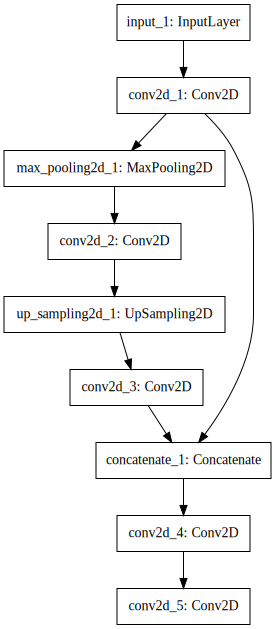

In [0]:
visualise_model(denoise_model, 'shallow_unet', rankdir='LR')

In [0]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

epochs = 20
minimum = float('inf')
val_loss_list = []
loss_list = []
for e in range(epochs):
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                verbose=1,
                                                epochs=1,
                                                validation_data=denoise_generator_val,
                                               )
  # Save best weights
  loss = denoise_history.history['loss'][0]
  val_loss = denoise_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    denoise_model.save(f'shallow_denoise_opt.h5')
  
  # Append to list
  loss_list.append(loss)
  val_loss_list.append(val_loss)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
31179/31179 [==============================] - 868s 28ms/step - loss: 6.6784 - mean_absolute_error: 6.6784 - val_loss: 5.9819 - val_mean_absolute_error: 5.9819
Epoch 1/1
31179/31179 [==============================] - 862s 28ms/step - loss: 6.1062 - mean_absolute_error: 6.1062 - val_loss: 5.8555 - val_mean_absolute_error: 5.8555
Epoch 1/1
31179/31179 [==============================] - 857s 28ms/step - loss: 5.9789 - mean_absolute_error: 5.9789 - val_loss: 5.7691 - val_mean_absolute_error: 5.7691
Epoch 1/1
31179/31179 [==============================] - 852s 27ms/step - loss: 5.9021 - mean_absolute_error: 5.9021 - val_loss: 5.7179 - val_mean_absolute_error: 5.7179
Epoch 1/1
31179/31179 [==============================] - 846s 27ms/step - loss: 5.8461 - mean_absolute_error: 5.8461 - val_loss: 5.7530 - val_mean_absolute_error: 5.7530
Epoch 1/1
31179/31179 [==============================] - 838s 27ms/step - loss: 5.7986 - mean_absolute

### 3.1.2 Load the optimal denoise model

In [0]:
denoise_model = keras.models.load_model('./shallow_denoise_opt.h5') # initialise with optimal weights

### 3.1.3 Visualisation of denoised images

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


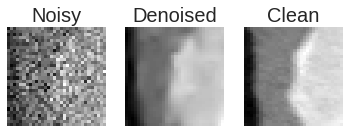

In [0]:
plot_denoise(denoise_model, selector=1)

## 3.2 Training a Descriptor Network

Initialise model

In [0]:
baseline_descriptor_model_trip, baseline_descriptor_model = load_descriptor_model(get_baseline_descriptor_model, optimizer=keras.optimizers.SGD(lr=0.1))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
___________________________

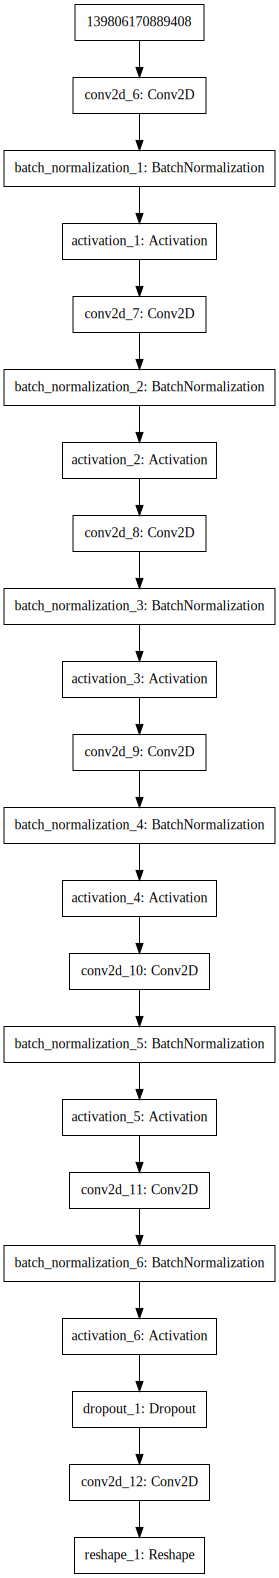

In [0]:
visualise_model(baseline_descriptor_model, 'hardnet')

### 3.2.1 Generating training and validation set 

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [00:38<00:00,  2.47it/s]
Denoising patches...
100%|██████████| 15589/15589 [04:08<00:00, 62.72it/s]


100%|██████████| 100000/100000 [00:01<00:00, 88729.17it/s]


Using denoised patches
100%|██████████| 116/116 [00:23<00:00,  5.03it/s]
Denoising patches...
100%|██████████| 9525/9525 [02:30<00:00, 63.87it/s]


100%|██████████| 10000/10000 [00:00<00:00, 89795.52it/s]


### 3.2.1 Visualisation of Inputs for Descriptor Model

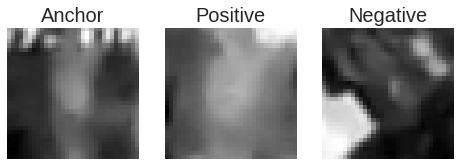

In [0]:
plot_triplet(training_generator)

### 3.2.2 Train the descriptor model

In [0]:
epochs = 20


minimum = float('inf')
for e in range(epochs):
  descriptor_history = baseline_descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  
  val_loss = descriptor_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    baseline_descriptor_model_trip.save(f'baseline_hardnet_opt.h5')
#   baseline_descriptor_model_trip.save(f'baseline_descriptor_{e+1}.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2190

100%|██████████| 100000/100000 [00:02<00:00, 43834.83it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.2190 - val_loss: 0.2959


100%|██████████| 10000/10000 [00:00<00:00, 73238.39it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1609

100%|██████████| 100000/100000 [00:02<00:00, 43988.22it/s]


2000/2000 [==============================] - 161s 81ms/step - loss: 0.1609 - val_loss: 0.3699


100%|██████████| 10000/10000 [00:00<00:00, 75770.32it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1442

100%|██████████| 100000/100000 [00:01<00:00, 59016.52it/s]


2000/2000 [==============================] - 161s 80ms/step - loss: 0.1442 - val_loss: 0.2502


100%|██████████| 10000/10000 [00:00<00:00, 88577.12it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1363

100%|██████████| 100000/100000 [00:02<00:00, 46290.58it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1362 - val_loss: 0.1577


100%|██████████| 10000/10000 [00:00<00:00, 88508.90it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1254

100%|██████████| 100000/100000 [00:01<00:00, 59261.34it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1255 - val_loss: 0.1737


100%|██████████| 10000/10000 [00:00<00:00, 81914.88it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1212

100%|██████████| 100000/100000 [00:01<00:00, 58334.70it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1211 - val_loss: 0.1392
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1179

100%|██████████| 100000/100000 [00:02<00:00, 46273.28it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1179 - val_loss: 0.1964
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1166

100%|██████████| 100000/100000 [00:02<00:00, 46051.97it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1167 - val_loss: 0.1414
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1081

100%|██████████| 100000/100000 [00:02<00:00, 47253.81it/s]


2000/2000 [==============================] - 159s 80ms/step - loss: 0.1081 - val_loss: 0.1529
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1061

100%|██████████| 100000/100000 [00:02<00:00, 45782.80it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1061 - val_loss: 0.1648


100%|██████████| 10000/10000 [00:00<00:00, 83085.47it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1036

100%|██████████| 100000/100000 [00:01<00:00, 57454.56it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.1037 - val_loss: 0.1548


100%|██████████| 10000/10000 [00:00<00:00, 86052.01it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1028

100%|██████████| 100000/100000 [00:01<00:00, 59101.04it/s]


2000/2000 [==============================] - 159s 80ms/step - loss: 0.1028 - val_loss: 0.1465
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1014

100%|██████████| 100000/100000 [00:01<00:00, 58030.73it/s]


2000/2000 [==============================] - 159s 79ms/step - loss: 0.1014 - val_loss: 0.1802
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0983

100%|██████████| 100000/100000 [00:02<00:00, 48360.27it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.0984 - val_loss: 0.1455


100%|██████████| 10000/10000 [00:00<00:00, 81764.77it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0977

100%|██████████| 100000/100000 [00:01<00:00, 56189.61it/s]


2000/2000 [==============================] - 159s 80ms/step - loss: 0.0977 - val_loss: 0.1351
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0946

100%|██████████| 100000/100000 [00:02<00:00, 47536.38it/s]


2000/2000 [==============================] - 160s 80ms/step - loss: 0.0947 - val_loss: 0.1418


100%|██████████| 10000/10000 [00:00<00:00, 79778.60it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0892

100%|██████████| 100000/100000 [00:02<00:00, 44839.84it/s]


2000/2000 [==============================] - 158s 79ms/step - loss: 0.0893 - val_loss: 0.1242
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0879

100%|██████████| 100000/100000 [00:01<00:00, 60963.15it/s]


2000/2000 [==============================] - 157s 79ms/step - loss: 0.0879 - val_loss: 0.1352
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0833

100%|██████████| 100000/100000 [00:02<00:00, 36874.43it/s]


2000/2000 [==============================] - 158s 79ms/step - loss: 0.0833 - val_loss: 0.1465
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0787

100%|██████████| 100000/100000 [00:02<00:00, 49470.69it/s]


2000/2000 [==============================] - 157s 79ms/step - loss: 0.0787 - val_loss: 0.1323


100%|██████████| 10000/10000 [00:00<00:00, 89417.44it/s]


### 3.2.3 Plot a graph of loss and validation loss

# 3.3 Verification, Matching and Retrieval Tasks
### 3.3.1 Verification
Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. 
### 3.3.2 Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.
### 3.3.3 Retrieval 
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
run_vmr('baseline', baseline_descriptor_model, denoise_model)

100%|██████████| 40/40 [06:30<00:00,  9.86s/it]


# 3 Optimise Denoise Model

## 3.1 Full Unet model

In [0]:
# autoencoder with skipping
def get_unet_denoise_model(shape):
  inputs = Input(shape)
  
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(conv5)

  ## Now the decoder starts

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  unet = Model(inputs = inputs, outputs = conv10)
  
  return unet

In [10]:
shape = (32, 32, 1)
denoise_unet_model = get_unet_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Visualise model

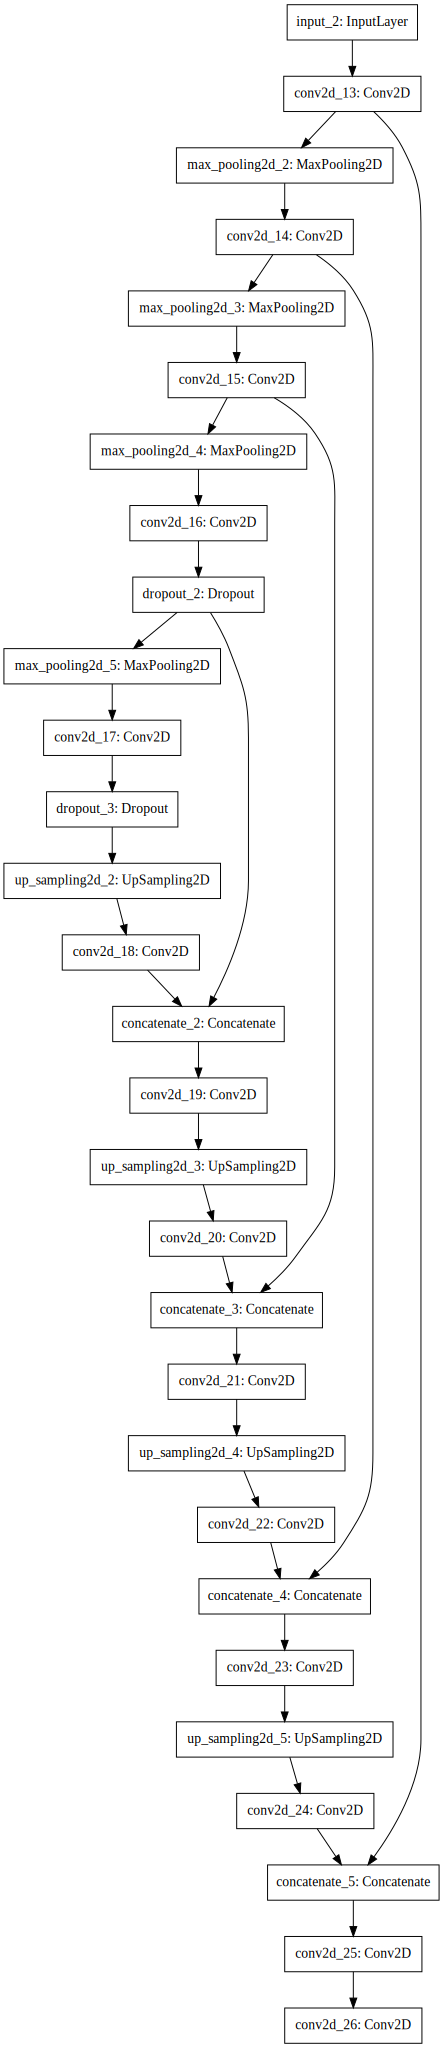

In [0]:
visualise_model(denoise_unet_model, 'full_unet_denoise')

## 3.1 Training Unet

In [0]:
denoise_unet_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])


epochs = 13
minimum = float('inf')

for e in range(epochs):
  denoise_unet_history = denoise_unet_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val)
  val_loss = denoise_unet_model.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    denoise_unet_model.save(f'full_unet_opt.h5')
#   denoise_unet_model.save(f'unet_denoise_{e+1}.h5')

Loading pretrained model

In [11]:
denoise_unet_model = keras.models.load_model('./unet_denoise_7.h5') #initialise with epoch 7

Instructions for updating:
Use tf.cast instead.


### 3.1.1 Visualisation

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


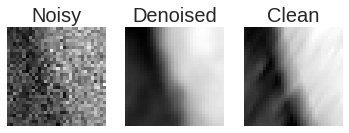

In [0]:
plot_denoise(denoise_unet_model, 1)

### 3.1.2 Comparison with Shallow U-Net

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


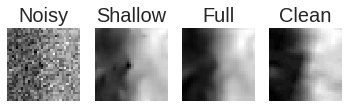

In [0]:
plot_compare_denoise(denoise_model, denoise_unet_model, denoised_title='Shallow', denoised_title2='Full')

# 4. Generate Training Set and Validation Set with Full Denoise Unet Model

In [12]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_unet_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [14:31<00:00,  8.52s/it]
Denoising patches...
100%|██████████| 15589/15589 [22:55<00:00, 11.28it/s]


100%|██████████| 100000/100000 [00:01<00:00, 69518.99it/s]


Using denoised patches
100%|██████████| 116/116 [07:28<00:00,  3.87s/it]
Denoising patches...
100%|██████████| 9525/9525 [13:57<00:00, 11.41it/s]


100%|██████████| 10000/10000 [00:00<00:00, 76340.86it/s]


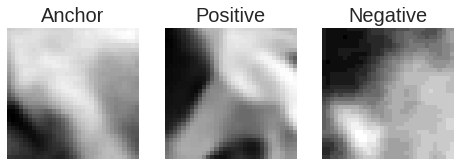

In [0]:
plot_triplet(training_generator)

## 4.1 Train HardNet with Full U-Net

In [14]:
unet_baseline_descriptor_model_trip, unet_baseline_descriptor_model = load_descriptor_model(get_baseline_descriptor_model, optimizer=keras.optimizers.SGD(lr=0.1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [15]:
epochs = 20


minimum = float('inf')
for e in range(epochs):
  descriptor_history = unet_baseline_descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  
  val_loss = descriptor_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    unet_baseline_descriptor_model_trip.save(f'unet_baseline_hardnet_opt.h5')
#   baseline_descriptor_model_trip.save(f'baseline_descriptor_{e+1}.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2053

100%|██████████| 100000/100000 [00:02<00:00, 43428.03it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.2054 - val_loss: 0.3800


100%|██████████| 10000/10000 [00:00<00:00, 77878.10it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1514

100%|██████████| 100000/100000 [00:02<00:00, 42827.09it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.1514 - val_loss: 0.1787


100%|██████████| 10000/10000 [00:00<00:00, 76284.35it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1356

100%|██████████| 100000/100000 [00:02<00:00, 45357.17it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.1356 - val_loss: 0.1791


100%|██████████| 10000/10000 [00:00<00:00, 68474.86it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1301

100%|██████████| 100000/100000 [00:02<00:00, 36225.02it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.1300 - val_loss: 0.1600


100%|██████████| 10000/10000 [00:00<00:00, 65390.61it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1191

100%|██████████| 100000/100000 [00:02<00:00, 45733.33it/s]


2000/2000 [==============================] - 166s 83ms/step - loss: 0.1191 - val_loss: 0.1680
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1143

100%|██████████| 100000/100000 [00:02<00:00, 43809.22it/s]


2000/2000 [==============================] - 167s 83ms/step - loss: 0.1143 - val_loss: 0.1515
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1117

100%|██████████| 100000/100000 [00:02<00:00, 39686.04it/s]


2000/2000 [==============================] - 166s 83ms/step - loss: 0.1117 - val_loss: 0.1391


100%|██████████| 10000/10000 [00:00<00:00, 69891.20it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1108

100%|██████████| 100000/100000 [00:02<00:00, 42289.61it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.1109 - val_loss: 0.1587


100%|██████████| 10000/10000 [00:00<00:00, 76510.61it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1040

100%|██████████| 100000/100000 [00:02<00:00, 47974.70it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.1040 - val_loss: 0.1545


100%|██████████| 10000/10000 [00:00<00:00, 72509.36it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1011

100%|██████████| 100000/100000 [00:02<00:00, 42032.35it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.1012 - val_loss: 0.1823


100%|██████████| 10000/10000 [00:00<00:00, 71684.39it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0999

100%|██████████| 100000/100000 [00:02<00:00, 41685.76it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0998 - val_loss: 0.1452


100%|██████████| 10000/10000 [00:00<00:00, 73163.78it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0973

100%|██████████| 100000/100000 [00:02<00:00, 43439.32it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0974 - val_loss: 0.1361


100%|██████████| 10000/10000 [00:00<00:00, 71674.23it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0979

100%|██████████| 100000/100000 [00:02<00:00, 48083.60it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0979 - val_loss: 0.1396
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0948

100%|██████████| 100000/100000 [00:02<00:00, 42943.95it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0947 - val_loss: 0.1227
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0929

100%|██████████| 100000/100000 [00:02<00:00, 42902.90it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0929 - val_loss: 0.1196


100%|██████████| 10000/10000 [00:00<00:00, 74428.85it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0931

100%|██████████| 100000/100000 [00:02<00:00, 42490.41it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0931 - val_loss: 0.1398
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0911

100%|██████████| 100000/100000 [00:02<00:00, 42630.16it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.0911 - val_loss: 0.1410


100%|██████████| 10000/10000 [00:00<00:00, 77083.18it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0900

100%|██████████| 100000/100000 [00:02<00:00, 42594.40it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.0900 - val_loss: 0.1245
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0893

100%|██████████| 100000/100000 [00:02<00:00, 42709.14it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.0894 - val_loss: 0.1201


100%|██████████| 10000/10000 [00:00<00:00, 71090.86it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0873

100%|██████████| 100000/100000 [00:02<00:00, 41827.72it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.0873 - val_loss: 0.1090


100%|██████████| 10000/10000 [00:00<00:00, 73757.68it/s]


## 4.2 Load optimal model

In [28]:
unet_baseline_descriptor_model_trip, unet_baseline_descriptor_model = load_descriptor_model(get_baseline_descriptor_model, './unet_baseline_hardnet_opt.h5', optimizer=keras.optimizers.SGD(lr=0.1), )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_62 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_63 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_83 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 64)        18496     
__________

# 5. Optimise Descriptor Model

## 5.1 Deeper HardNet V1

In [0]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add, Input, Activation, Flatten, MaxPooling2D, UpSampling2D, concatenate

# V1 uses fully connected layer
def get_deep_hardnet_v1_model(shape):
  
  '''Architecture adapts HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  descriptor_input = Input(shape)
  
  # 2 layers of 32x32x32 layers + BN + ReLU
  descriptor_model = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(descriptor_input)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 16x16x64 + BN + ReLU
  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 8x8x128 + BN + ReLU
  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 4x4x256 + BN + ReLU
  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Add 2 residual network to reduce dimension further to 2 and back to 4
  descriptor_model = residual_block(descriptor_model, 256, 256, _strides=(2,2))
  descriptor_model = residual_block(descriptor_model, 256, 256, _strides=(2,2))
  
  # Passing to fully connected layer
  # It will have 4x4x256 number of features
  descriptor_model = Flatten()(descriptor_model)
  # BN to normalise input
  descriptor_model = BatchNormalization()(descriptor_model)
  # Drop out to prevent overfitting
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  # Reduce to 512
  descriptor_model = Dense(512, activation='relu')(descriptor_model)
  # BN to normalise input
  descriptor_model = BatchNormalization()(descriptor_model)
  # Drop out to prevent overfitting
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  # Reduce to 256
  descriptor_model = Dense(256, activation='relu')(descriptor_model)
  # BN to normalise input
  descriptor_model = BatchNormalization()(descriptor_model)
  # Drop out to prevent overfitting
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  # Reduce to 128
  descriptor_model = Dense(128, activation='relu')(descriptor_model)
  # BN to normalise input
#   descriptor_model = BatchNormalization()(descriptor_model)
#   # Drop out to prevent overfitting
#   descriptor_model = Dropout(0.3)(descriptor_model)
  
  # Output 128 features
  return Model(descriptor_input, descriptor_model)


def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):

    shortcut = y

    y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_in, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    
#     up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
    
    y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(UpSampling2D(size=_strides)(y))
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
#     if _project_shortcut or _strides != (1, 1):
#         # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
#         # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
#         shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
#         shortcut = BatchNormalization()(shortcut)

    y = concatenate([shortcut, y], axis = -1)
    y = LeakyReLU()(y)

    return y

We add residual_block to HardNet to skip some layers

In [20]:
deeper_hardnet_fully_connected_model_trip, deeper_hardnet_fully_connected_model = load_descriptor_model(get_deep_hardnet_v1_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 32, 32, 32)   128         conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 32, 32, 32)   0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
conv2d_44 

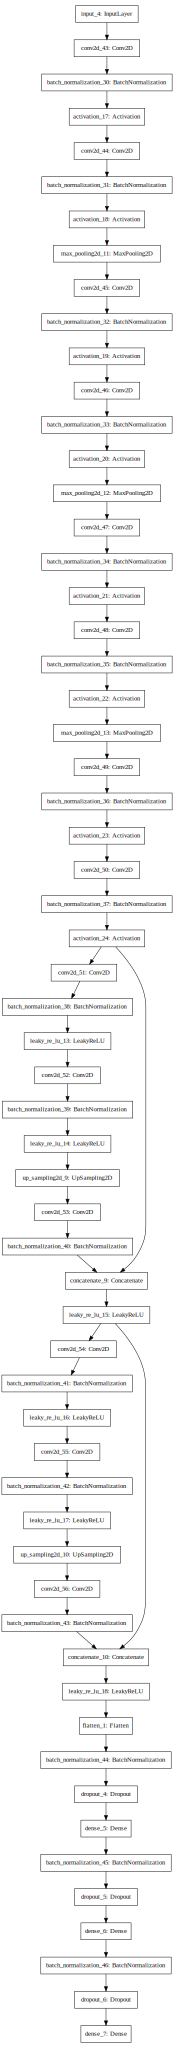

In [21]:
visualise_model(deeper_hardnet_fully_connected_model, 'deep_hardnet_fully_connected')

In [22]:
epochs = 20


minimum = float('inf')
for e in range(epochs):
  descriptor_history = deeper_hardnet_fully_connected_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  
  val_loss = descriptor_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    deeper_hardnet_fully_connected_model_trip.save(f'deep_hardnet_v1_opt.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2717

100%|██████████| 100000/100000 [00:02<00:00, 39841.49it/s]


2000/2000 [==============================] - 398s 199ms/step - loss: 0.2717 - val_loss: 0.2622


100%|██████████| 10000/10000 [00:00<00:00, 70266.47it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2246

100%|██████████| 100000/100000 [00:02<00:00, 40675.15it/s]


2000/2000 [==============================] - 384s 192ms/step - loss: 0.2245 - val_loss: 0.3139


100%|██████████| 10000/10000 [00:00<00:00, 69421.66it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2150

100%|██████████| 100000/100000 [00:02<00:00, 34210.53it/s]


2000/2000 [==============================] - 385s 193ms/step - loss: 0.2150 - val_loss: 0.2508
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2038

100%|██████████| 100000/100000 [00:02<00:00, 40608.68it/s]


2000/2000 [==============================] - 385s 193ms/step - loss: 0.2038 - val_loss: 0.2381
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1956

100%|██████████| 100000/100000 [00:02<00:00, 42535.79it/s]


2000/2000 [==============================] - 385s 192ms/step - loss: 0.1956 - val_loss: 0.2311


100%|██████████| 10000/10000 [00:00<00:00, 68497.56it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1776

100%|██████████| 100000/100000 [00:02<00:00, 41502.34it/s]


2000/2000 [==============================] - 385s 193ms/step - loss: 0.1776 - val_loss: 0.2156
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1697

100%|██████████| 100000/100000 [00:02<00:00, 44001.34it/s]


2000/2000 [==============================] - 386s 193ms/step - loss: 0.1697 - val_loss: 0.2068
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1640

100%|██████████| 100000/100000 [00:02<00:00, 39529.06it/s]


2000/2000 [==============================] - 385s 192ms/step - loss: 0.1640 - val_loss: 0.1915
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1596

100%|██████████| 100000/100000 [00:02<00:00, 43016.55it/s]


2000/2000 [==============================] - 385s 192ms/step - loss: 0.1596 - val_loss: 0.1979


100%|██████████| 10000/10000 [00:00<00:00, 71912.13it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1555

100%|██████████| 100000/100000 [00:02<00:00, 39763.20it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1555 - val_loss: 0.2059


100%|██████████| 10000/10000 [00:00<00:00, 70293.32it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1540

100%|██████████| 100000/100000 [00:02<00:00, 40160.63it/s]


2000/2000 [==============================] - 389s 194ms/step - loss: 0.1540 - val_loss: 0.1712
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1508

100%|██████████| 100000/100000 [00:03<00:00, 32501.56it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1509 - val_loss: 0.1751


100%|██████████| 10000/10000 [00:00<00:00, 69053.29it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1465

100%|██████████| 100000/100000 [00:02<00:00, 39875.12it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1466 - val_loss: 0.1880


100%|██████████| 10000/10000 [00:00<00:00, 67988.69it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1452

100%|██████████| 100000/100000 [00:02<00:00, 40059.72it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1452 - val_loss: 0.1764
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1422

100%|██████████| 100000/100000 [00:03<00:00, 32265.13it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1422 - val_loss: 0.1734


100%|██████████| 10000/10000 [00:00<00:00, 68214.37it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1421

100%|██████████| 100000/100000 [00:02<00:00, 40838.33it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1421 - val_loss: 0.1783


100%|██████████| 10000/10000 [00:00<00:00, 69852.21it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1401

100%|██████████| 100000/100000 [00:02<00:00, 40624.99it/s]


2000/2000 [==============================] - 389s 194ms/step - loss: 0.1401 - val_loss: 0.1710
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1392

100%|██████████| 100000/100000 [00:03<00:00, 31878.66it/s]


2000/2000 [==============================] - 388s 194ms/step - loss: 0.1392 - val_loss: 0.1685


100%|██████████| 10000/10000 [00:00<00:00, 69147.21it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1337

100%|██████████| 100000/100000 [00:02<00:00, 39939.35it/s]


2000/2000 [==============================] - 390s 195ms/step - loss: 0.1337 - val_loss: 0.2008


100%|██████████| 10000/10000 [00:00<00:00, 62721.66it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1383

100%|██████████| 100000/100000 [00:02<00:00, 40851.15it/s]


2000/2000 [==============================] - 387s 194ms/step - loss: 0.1382 - val_loss: 0.1718


## 5.1.1 Load optimal model

In [29]:
deeper_hardnet_fully_connected_model_trip, deeper_hardnet_fully_connected_model = load_descriptor_model(get_deep_hardnet_v1_model, './deep_hardnet_v1_opt.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 32, 32, 32)   128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 32, 32, 32)   0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
conv2d_79 

## 5.2 Deep HardNet V2

In [0]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add, Input, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D

# V1 uses fully connected layer
def get_deep_hardnet_v2_model(shape):
  
  '''Architecture adapts HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  descriptor_input = Input(shape)
  
  # 2 layers of 32x32x32 layers + BN + ReLU
  descriptor_model = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(descriptor_input)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 16x16x64 + BN + ReLU
  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 8x8x128 + BN + ReLU
  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  # Use Max Pooling to reduce image dimension
  descriptor_model = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(descriptor_model)
  
  # 2 layers of 4x4x256 + BN + ReLU
#   descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
#   descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
#   descriptor_model = Activation('relu')(descriptor_model)

#   descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
#   descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
#   descriptor_model = Activation('relu')(descriptor_model)
  
  # Add 2 residual network to reduce dimension further to 2 and back to 4
  descriptor_model = residual_block(descriptor_model, 128, 128, _strides=(2,2))
  descriptor_model = residual_block(descriptor_model, 128, 128, _strides=(2,2))

  # Instead of fully connected layer, we use GlobalAverage2D 
  descriptor_model = GlobalAveragePooling2D()(descriptor_model)
#   # let's add a fully-connected layer
#   descriptor_model = Flatten()(descriptor_model)
  descriptor_model = Dense(256, activation='relu')(descriptor_model)
  descriptor_model = BatchNormalization()(descriptor_model)
  # Drop out to prevent overfitting
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  descriptor_model = Dense(128, activation='relu')(descriptor_model)

#   # and a logistic layer -- let's say we have 200 classes
#   descriptor_model = Dense(128, activation='sigmoid')(descriptor_model)
  
  # Output 128 features
  return Model(descriptor_input, descriptor_model)


def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1)):

    shortcut = y

    y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_in, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    
#     up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
    
    y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(UpSampling2D(size=_strides)(y))
    y = BatchNormalization()(y)

    y = concatenate([shortcut, y], axis = -1)
    y = LeakyReLU()(y)

    return y

In [14]:
deeper_hardnet_v2_trip, deeper_hardnet_v2_model = load_descriptor_model(get_deep_hardnet_v2_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_16 

In [15]:
epochs = 20

minimum = float('inf')
for e in range(epochs):
  descriptor_history = deeper_hardnet_v2_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  
  val_loss = descriptor_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    deeper_hardnet_v2_trip.save(f'deep_hardnet_v2_opt.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2422

100%|██████████| 100000/100000 [00:02<00:00, 48526.53it/s]


2000/2000 [==============================] - 237s 119ms/step - loss: 0.2422 - val_loss: 0.2510


100%|██████████| 10000/10000 [00:00<00:00, 73600.16it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1878

100%|██████████| 100000/100000 [00:02<00:00, 47196.61it/s]


2000/2000 [==============================] - 225s 112ms/step - loss: 0.1878 - val_loss: 0.2397
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1725

100%|██████████| 100000/100000 [00:02<00:00, 48957.02it/s]


2000/2000 [==============================] - 225s 112ms/step - loss: 0.1725 - val_loss: 0.2105


100%|██████████| 10000/10000 [00:00<00:00, 74499.18it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1632

100%|██████████| 100000/100000 [00:02<00:00, 49863.94it/s]


2000/2000 [==============================] - 224s 112ms/step - loss: 0.1632 - val_loss: 0.2078
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1507

100%|██████████| 100000/100000 [00:02<00:00, 45009.54it/s]


2000/2000 [==============================] - 225s 112ms/step - loss: 0.1507 - val_loss: 0.2166
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1485

100%|██████████| 100000/100000 [00:02<00:00, 42215.10it/s]


2000/2000 [==============================] - 223s 112ms/step - loss: 0.1486 - val_loss: 0.2001


100%|██████████| 10000/10000 [00:00<00:00, 72339.53it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1456

100%|██████████| 100000/100000 [00:02<00:00, 41336.07it/s]


2000/2000 [==============================] - 221s 110ms/step - loss: 0.1456 - val_loss: 0.1792


100%|██████████| 10000/10000 [00:00<00:00, 74603.34it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1416

100%|██████████| 100000/100000 [00:02<00:00, 39829.93it/s]


2000/2000 [==============================] - 222s 111ms/step - loss: 0.1417 - val_loss: 0.1706


100%|██████████| 10000/10000 [00:00<00:00, 74011.47it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1364

100%|██████████| 100000/100000 [00:02<00:00, 40045.15it/s]


2000/2000 [==============================] - 223s 111ms/step - loss: 0.1364 - val_loss: 0.2286


100%|██████████| 10000/10000 [00:00<00:00, 66012.11it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1334

100%|██████████| 100000/100000 [00:02<00:00, 41210.68it/s]


2000/2000 [==============================] - 224s 112ms/step - loss: 0.1334 - val_loss: 0.1737


100%|██████████| 10000/10000 [00:00<00:00, 72070.17it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1313

100%|██████████| 100000/100000 [00:02<00:00, 48416.50it/s]


2000/2000 [==============================] - 222s 111ms/step - loss: 0.1314 - val_loss: 0.1641


100%|██████████| 10000/10000 [00:00<00:00, 74142.43it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1293

100%|██████████| 100000/100000 [00:02<00:00, 41448.63it/s]


2000/2000 [==============================] - 223s 112ms/step - loss: 0.1293 - val_loss: 0.1611
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1282

100%|██████████| 100000/100000 [00:02<00:00, 47506.05it/s]


2000/2000 [==============================] - 222s 111ms/step - loss: 0.1282 - val_loss: 0.1687


100%|██████████| 10000/10000 [00:00<00:00, 73907.40it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1218

100%|██████████| 100000/100000 [00:02<00:00, 47850.82it/s]


2000/2000 [==============================] - 223s 111ms/step - loss: 0.1218 - val_loss: 0.1602


100%|██████████| 10000/10000 [00:00<00:00, 67831.02it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1249

100%|██████████| 100000/100000 [00:02<00:00, 47909.09it/s]


2000/2000 [==============================] - 222s 111ms/step - loss: 0.1249 - val_loss: 0.1584
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1226

100%|██████████| 100000/100000 [00:02<00:00, 46612.23it/s]


2000/2000 [==============================] - 222s 111ms/step - loss: 0.1226 - val_loss: 0.1628


100%|██████████| 10000/10000 [00:00<00:00, 70514.67it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1197

100%|██████████| 100000/100000 [00:02<00:00, 47040.94it/s]


2000/2000 [==============================] - 228s 114ms/step - loss: 0.1197 - val_loss: 0.1539
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1192

100%|██████████| 100000/100000 [00:02<00:00, 41334.64it/s]


2000/2000 [==============================] - 224s 112ms/step - loss: 0.1192 - val_loss: 0.1533


100%|██████████| 10000/10000 [00:00<00:00, 74174.42it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1160

100%|██████████| 100000/100000 [00:02<00:00, 40231.48it/s]


2000/2000 [==============================] - 224s 112ms/step - loss: 0.1161 - val_loss: 0.1377


100%|██████████| 10000/10000 [00:00<00:00, 72886.24it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1159

100%|██████████| 100000/100000 [00:02<00:00, 40751.84it/s]


2000/2000 [==============================] - 224s 112ms/step - loss: 0.1159 - val_loss: 0.1429


100%|██████████| 10000/10000 [00:00<00:00, 66134.41it/s]


### 5.2.1 Load optimal model

In [16]:
deeper_hardnet_v2_trip, deeper_hardnet_v2_model = load_descriptor_model(get_deep_hardnet_v2_model, './deep_hardnet_v2_opt.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 32)   128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 32)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv2d_28 

# 6. ResNet

In [0]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.backend import tf as ktf
from keras.layers import Lambda, Input

def get_resnet_50_descriptor_model(shape):
  model = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

  # Resize Input images to 75x75
  newInput = Input(batch_shape=(None, shape[0], shape[1], shape[2]))
# #   resizedImg = Lambda(lambda image: ktf.image.resize_images(image, (75, 75)))(newInput)
  if shape[2] == 1:
    resizedImg = Lambda(lambda image: ktf.image.grayscale_to_rgb(image))(newInput)
  newOutputs = model(resizedImg)
  model = Model(newInput, newOutputs)

  for layer in model.layers[:]:
      layer.trainable = False
  
  output = model.output

  output = GlobalAveragePooling2D()(output)
  # let's add a fully-connected layer
  output = Dense(256, activation='relu')(output)
  # and a logistic layer -- let's say we have 200 classes
  output = Dense(128, activation='relu')(output)

  return Model(model.input, output)

In [24]:
resnet_model_trip, resnet_model = load_descriptor_model(get_resnet_50_descriptor_model)

94658560/94653016 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
Total params: 24,145,152
Trainable params: 557,440
Non-trainable params: 23,5

In [25]:
epochs = 20

minimum = float('inf')
for e in range(epochs):
  descriptor_history = resnet_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  
  val_loss = descriptor_history.history['val_loss'][0]
  if val_loss < minimum:
    minimum = min(minimum, val_loss)
    resnet_model_trip.save(f'resnet_opt.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.4363

100%|██████████| 100000/100000 [00:02<00:00, 38264.52it/s]


2000/2000 [==============================] - 249s 124ms/step - loss: 0.4362 - val_loss: 0.4644


100%|██████████| 10000/10000 [00:00<00:00, 73528.42it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3590

100%|██████████| 100000/100000 [00:02<00:00, 34165.88it/s]


2000/2000 [==============================] - 231s 115ms/step - loss: 0.3590 - val_loss: 0.4609


100%|██████████| 10000/10000 [00:00<00:00, 69765.30it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3347

100%|██████████| 100000/100000 [00:02<00:00, 36778.75it/s]


2000/2000 [==============================] - 231s 115ms/step - loss: 0.3347 - val_loss: 0.4306


100%|██████████| 10000/10000 [00:00<00:00, 69691.00it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3205

100%|██████████| 100000/100000 [00:02<00:00, 36670.00it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.3205 - val_loss: 0.4856


100%|██████████| 10000/10000 [00:00<00:00, 72773.68it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3147

100%|██████████| 100000/100000 [00:02<00:00, 35761.52it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.3147 - val_loss: 0.4291


100%|██████████| 10000/10000 [00:00<00:00, 64002.64it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3078

100%|██████████| 100000/100000 [00:02<00:00, 38078.27it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.3078 - val_loss: 0.4815


100%|██████████| 10000/10000 [00:00<00:00, 70160.69it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2996

100%|██████████| 100000/100000 [00:03<00:00, 27779.15it/s]


2000/2000 [==============================] - 231s 116ms/step - loss: 0.2995 - val_loss: 0.4680


100%|██████████| 10000/10000 [00:00<00:00, 71309.02it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3012

100%|██████████| 100000/100000 [00:02<00:00, 35039.28it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.3013 - val_loss: 0.4551


100%|██████████| 10000/10000 [00:00<00:00, 72120.98it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.3002

100%|██████████| 100000/100000 [00:02<00:00, 35651.37it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.3002 - val_loss: 0.4484


100%|██████████| 10000/10000 [00:00<00:00, 71344.32it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2948

100%|██████████| 100000/100000 [00:02<00:00, 36853.27it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2948 - val_loss: 0.4311


100%|██████████| 10000/10000 [00:00<00:00, 71002.65it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2946

100%|██████████| 100000/100000 [00:02<00:00, 37298.20it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2946 - val_loss: 0.4573


100%|██████████| 10000/10000 [00:00<00:00, 73790.77it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2897

100%|██████████| 100000/100000 [00:02<00:00, 34806.44it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2897 - val_loss: 0.4622


100%|██████████| 10000/10000 [00:00<00:00, 69213.17it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2876

100%|██████████| 100000/100000 [00:02<00:00, 35541.84it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2876 - val_loss: 0.4465


100%|██████████| 10000/10000 [00:00<00:00, 70834.65it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2892

100%|██████████| 100000/100000 [00:02<00:00, 36045.60it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2892 - val_loss: 0.4313


100%|██████████| 10000/10000 [00:00<00:00, 70550.84it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2870

100%|██████████| 100000/100000 [00:02<00:00, 35660.54it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.2870 - val_loss: 0.4284


100%|██████████| 10000/10000 [00:00<00:00, 70106.04it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2854

100%|██████████| 100000/100000 [00:02<00:00, 36387.82it/s]


2000/2000 [==============================] - 230s 115ms/step - loss: 0.2853 - val_loss: 0.4198


100%|██████████| 10000/10000 [00:00<00:00, 70890.80it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2798

100%|██████████| 100000/100000 [00:02<00:00, 35961.89it/s]


2000/2000 [==============================] - 229s 114ms/step - loss: 0.2798 - val_loss: 0.4457


100%|██████████| 10000/10000 [00:00<00:00, 70135.46it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2859

100%|██████████| 100000/100000 [00:02<00:00, 37998.78it/s]


2000/2000 [==============================] - 228s 114ms/step - loss: 0.2859 - val_loss: 0.4476


100%|██████████| 10000/10000 [00:00<00:00, 70627.82it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2852

100%|██████████| 100000/100000 [00:02<00:00, 37552.36it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2853 - val_loss: 0.4701


100%|██████████| 10000/10000 [00:00<00:00, 66323.38it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2840

100%|██████████| 100000/100000 [00:03<00:00, 26737.81it/s]


2000/2000 [==============================] - 229s 115ms/step - loss: 0.2840 - val_loss: 0.4386


100%|██████████| 10000/10000 [00:00<00:00, 73254.00it/s]


## 6.1 Load optimal model

In [0]:
resnet_model_trip, resnet_model = load_descriptor_model(get_resnet_50_descriptor_model, './resnet_opt.h5')

# 7. Evaluation

In [34]:
run_vmr('unet_baseline_hardnet', unet_baseline_descriptor_model, denoise_unet_model)

Output: 

>> Running HPatch evaluation for unet_baseline_hardnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
>> Verification task finished in 287 secs  
Verification task results:
Mean Average Precision is 0.824511

Output: 

>> Running HPatch evaluation for unet_baseline_hardnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
>> Matching task finished in 132 secs  
Matching task results:
Mean Average Precision is 0.235052



Output: 

>> Running HPatch evaluation for unet_baseline_hardnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
>> Retrieval task finished in 252 secs  
Retrieval task results:
Mean Average Precision is 0.537885



In [35]:
run_vmr('unet_hardnet_v1', deeper_hardnet_fully_connected_model, denoise_unet_model)

100%|██████████| 40/40 [24:03<00:00, 36.86s/it]


Output: 

>> Running HPatch evaluation for unet_hardnet_v1
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
>> Verification task finished in 292 secs  
Verification task results:
Mean Average Precision is 0.748667

Output: 

>> Running HPatch evaluation for unet_hardnet_v1
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
>> Matching task finished in 132 secs  
Matching task results:
Mean Average Precision is 0.035623



Output: 

>> Running HPatch evaluation for unet_hardnet_v1
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
>> Retrieval task finished in 253 secs  
Retrieval task results:
Mean Average Precision is 0.305305



In [17]:
run_vmr('unet_hardnet_v2', deeper_hardnet_v2_model, denoise_unet_model)

100%|██████████| 40/40 [18:18<00:00, 28.60s/it]


Output: 

>> Running HPatch evaluation for unet_hardnet_v2
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
>> Verification task finished in 293 secs  
Verification task results:
Mean Average Precision is 0.783372

Output: 

>> Running HPatch evaluation for unet_hardnet_v2
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
>> Matching task finished in 129 secs  
Matching task results:
Mean Average Precision is 0.079709



Output: 

>> Running HPatch evaluation for unet_hardnet_v2
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
>> Retrieval task finished in 250 secs  
Retrieval task results:
Mean Average Precision is 0.387180



In [38]:
run_vmr('resnet', resnet_model, denoise_unet_model)


100%|██████████| 40/40 [36:51<00:00, 57.16s/it]


Output: 

>> Running HPatch evaluation for resnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
>> Verification task finished in 326 secs  
Verification task results:
Mean Average Precision is 0.490459

Output: 

>> Running HPatch evaluation for resnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
>> Matching task finished in 133 secs  
Matching task results:
Mean Average Precision is 0.002654



Output: 

>> Running HPatch evaluation for resnet
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
>> Retrieval task finished in 255 secs  
Retrieval task results:
Mean Average Precision is 0.136337



# 8. Miscellaneous
Plan
1. Use full unet to denoise 
 * Describe Unet as autoencoder and skipping neurones
 * Check loss and val loss
 * Check image quality, show figures 
2. Comment on the use of MAE, why MAE instead of MSE
3. Use other models, such as ResNet, InceptionV3, 1 custom net

You will also notice that the beginning of the name of each of those variables corresponds to the name of one of the BatchNormalization layers and that each layer has a moving_mean and a moving_variance. Indeed, fchollet is stating himself in a conversation on an issue in the keras-team repository that this is the normal behavior for the BatchNormalization layers:
```
batchnorm also maintains non-trainable weights, which are updated via layer updates (i.e. not through backprop): the mean and variance vectors.
```
TLTR: The number of none trainable weights of the model comes from the BatchNormalization layers whose mean and variance vectors are updated via layer updates instead of backpropagation and therefore are considered as none trainable parameters.

Not learning, with loss stagnant at 1.0

## 8.1 Old Deeper HardNet

In [0]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add, Input, Activation

def get_my_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  descriptor_input = Input(shape)
  
#   descriptor_model = Sequential()
  descriptor_model = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(descriptor_input)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = residual_block(descriptor_model, 256, 256)
  
  descriptor_model = Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  
  # Final descriptor reshape
  descriptor_model = Reshape((128,))(descriptor_model)
  
#   descriptor_model.output
  
  return Model(descriptor_input, descriptor_model)


def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):

    shortcut = y

    y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_in, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)

xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
my_descriptor_model = get_my_descriptor_model(shape)
ea = my_descriptor_model(xa)
ep = my_descriptor_model(xp)
en = my_descriptor_model(xn)
my_descriptor_model.summary()
loss = Lambda(triplet_loss)([ea, ep, en])


my_descriptor_model_trip = Model(inputs = [xa, xp, xn], outputs = loss)
# sgd = keras.optimizers.SGD(lr = 0.1)
my_descriptor_model_trip.compile(loss='mean_absolute_error', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_696 (Conv2D)             (None, 32, 32, 32)   320         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_677 (BatchN (None, 32, 32, 32)   128         conv2d_696[0][0]                 
__________________________________________________________________________________________________
activation_647 (Activation)     (None, 32, 32, 32)   0           batch_normalization_677[0][0]    
__________________________________________________________________________________________________
conv2d_697

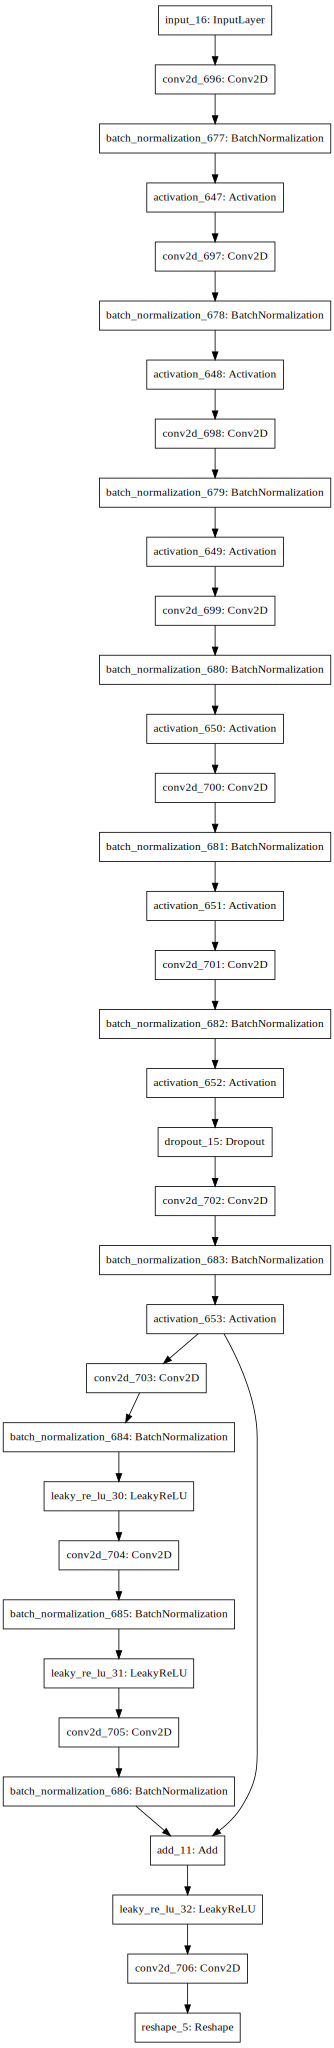

In [0]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
 
plot_model(my_descriptor_model, to_file='my_descriptor_model.png', show_shapes=True, show_layer_names=True)
 
SVG(model_to_dot(my_descriptor_model).create(prog='dot', format='svg'))

In [0]:
epochs = 10
for e in range(epochs):
  descriptor_history = my_descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  my_descriptor_model_trip.save(f'my_descriptor_{e+10}.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1035

100%|██████████| 100000/100000 [00:02<00:00, 34327.70it/s]


2000/2000 [==============================] - 342s 171ms/step - loss: 0.1036 - val_loss: 0.1555


100%|██████████| 10000/10000 [00:00<00:00, 66609.03it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0992

100%|██████████| 100000/100000 [00:03<00:00, 33147.85it/s]


2000/2000 [==============================] - 342s 171ms/step - loss: 0.0992 - val_loss: 0.1510


100%|██████████| 10000/10000 [00:00<00:00, 67796.37it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0976

100%|██████████| 100000/100000 [00:02<00:00, 37631.12it/s]


2000/2000 [==============================] - 340s 170ms/step - loss: 0.0975 - val_loss: 0.1402


100%|██████████| 10000/10000 [00:00<00:00, 68198.62it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0978

100%|██████████| 100000/100000 [00:02<00:00, 35881.72it/s]


2000/2000 [==============================] - 332s 166ms/step - loss: 0.0978 - val_loss: 0.1297


100%|██████████| 10000/10000 [00:00<00:00, 62243.97it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0945

100%|██████████| 100000/100000 [00:02<00:00, 35903.06it/s]


2000/2000 [==============================] - 332s 166ms/step - loss: 0.0945 - val_loss: 0.1339


100%|██████████| 10000/10000 [00:00<00:00, 68962.35it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0939

100%|██████████| 100000/100000 [00:02<00:00, 36996.24it/s]


2000/2000 [==============================] - 331s 166ms/step - loss: 0.0939 - val_loss: 0.1243


100%|██████████| 10000/10000 [00:00<00:00, 68251.45it/s]


Epoch 1/1
1473/2000 [=====================>........] - ETA: 1:27 - loss: 0.0924

## 8.2 HardNet V2

In [0]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add, Input, Activation

def get_my_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  descriptor_input = Input(shape)
  
#   descriptor_model = Sequential()
  descriptor_model = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(descriptor_input)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = residual_block(descriptor_model, 256, 256)
  
  descriptor_model = Conv2D(512, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = residual_block(descriptor_model, 512, 512)
  
  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = Dropout(0.3)(descriptor_model)
  
  descriptor_model = Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  
  # Final descriptor reshape
  descriptor_model = Reshape((128,))(descriptor_model)
  
#   descriptor_model.output
  
  return Model(descriptor_input, descriptor_model)


def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):

    shortcut = y

    y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_in, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)

xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
my_descriptor_model = get_my_descriptor_model(shape)
ea = my_descriptor_model(xa)
ep = my_descriptor_model(xp)
en = my_descriptor_model(xn)
my_descriptor_model.summary()
loss = Lambda(triplet_loss)([ea, ep, en])


my_descriptor_model_trip = Model(inputs = [xa, xp, xn], outputs = loss)
# sgd = keras.optimizers.SGD(lr = 0.1)
my_descriptor_model_trip.compile(loss='mean_absolute_error', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_16 

In [0]:
epochs = 10
for e in range(epochs):
  descriptor_history = my_descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  my_descriptor_model_trip.save(f'my_descriptor_v2_{e+10}.h5')

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1016

100%|██████████| 100000/100000 [00:02<00:00, 38295.05it/s]


2000/2000 [==============================] - 594s 297ms/step - loss: 0.1015 - val_loss: 0.1604


100%|██████████| 10000/10000 [00:00<00:00, 70720.59it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0968

100%|██████████| 100000/100000 [00:02<00:00, 37123.02it/s]


2000/2000 [==============================] - 595s 297ms/step - loss: 0.0967 - val_loss: 0.1492


100%|██████████| 10000/10000 [00:00<00:00, 24766.85it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0955

100%|██████████| 100000/100000 [00:02<00:00, 36491.05it/s]


2000/2000 [==============================] - 595s 297ms/step - loss: 0.0955 - val_loss: 0.1556


100%|██████████| 10000/10000 [00:00<00:00, 75387.63it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0889

100%|██████████| 100000/100000 [00:02<00:00, 39130.91it/s]


2000/2000 [==============================] - 596s 298ms/step - loss: 0.0889 - val_loss: 0.1559


100%|██████████| 10000/10000 [00:00<00:00, 74679.32it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0859

100%|██████████| 100000/100000 [00:02<00:00, 38134.42it/s]


2000/2000 [==============================] - 597s 299ms/step - loss: 0.0859 - val_loss: 0.1529


100%|██████████| 10000/10000 [00:00<00:00, 72604.63it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0846

100%|██████████| 100000/100000 [00:02<00:00, 39444.43it/s]


2000/2000 [==============================] - 596s 298ms/step - loss: 0.0846 - val_loss: 0.2176


100%|██████████| 10000/10000 [00:00<00:00, 72597.34it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0869

100%|██████████| 100000/100000 [00:02<00:00, 36641.33it/s]


2000/2000 [==============================] - 596s 298ms/step - loss: 0.0869 - val_loss: 0.1657


100%|██████████| 10000/10000 [00:00<00:00, 72468.64it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0810

100%|██████████| 100000/100000 [00:02<00:00, 36595.91it/s]


2000/2000 [==============================] - 596s 298ms/step - loss: 0.0810 - val_loss: 0.1772


100%|██████████| 10000/10000 [00:00<00:00, 73028.37it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0774

100%|██████████| 100000/100000 [00:02<00:00, 40107.94it/s]


2000/2000 [==============================] - 596s 298ms/step - loss: 0.0774 - val_loss: 0.1426


100%|██████████| 10000/10000 [00:00<00:00, 72921.08it/s]


Epoch 1/1
1118/2000 [===============>..............] - ETA: 4:14 - loss: 0.0835

## 8.3 HardNet V3

In [0]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add, Input, Activation, Flatten

def get_my_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  descriptor_input = Input(shape)
  
#   descriptor_model = Sequential()
  descriptor_model = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(descriptor_input)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)

  descriptor_model = Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = residual_block(descriptor_model, 256, 256)
  
  descriptor_model = Conv2D(512, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  descriptor_model = Activation('relu')(descriptor_model)
  
  descriptor_model = residual_block(descriptor_model, 512, 512)
  
  #descriptor_model = Conv2D(256, 3, padding='same', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  #descriptor_model = BatchNormalization(axis = -1)(descriptor_model)
  #descriptor_model = Activation('relu')(descriptor_model)
  # Passing to fully connected layer
  descriptor_model = Flatten()(descriptor_model)
  
  descriptor_model = Dense()
  # Drop out to prevent overfitting
  descriptor_model = Dropout(0.3)(descriptor_model)
  
#   descriptor_model = Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights)(descriptor_model)
  
  # Final descriptor reshape
  descriptor_model = Reshape((128,))(descriptor_model)
  
#   descriptor_model.output
  
  return Model(descriptor_input, descriptor_model)


def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):

    shortcut = y

    y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_in, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y